In [1]:
from gensim.models.phrases import Phrases, Phraser
from gensim.models import Word2Vec
import multiprocessing
from time import time
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [2]:
import ast
with open('sums.txt', 'r') as f:
    sums = ast.literal_eval(f.read())

In [3]:
sent = [item for item in [s.split() for s in sums]]

In [4]:
phrases = Phrases(sent, min_count=5)


In [5]:
bigram = Phraser(phrases)


In [6]:
sentences = bigram[sent]


In [7]:
w2v_model = Word2Vec(min_count=5,
                     window=5, #5
                     size=700,  #500
                     sample=1e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=multiprocessing.cpu_count()-1)

start = time()

w2v_model.build_vocab(sent)

print('Time to build vocab: {} mins'.format(round((time() - start) / 60, 2)))

Time to build vocab: 0.01 mins


In [8]:
len(w2v_model.wv.vocab)

3261

In [9]:
start = time()

w2v_model.train(sent, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - start) / 60, 2)))

w2v_model.init_sims(replace=True)

Time to train the model: 0.06 mins


In [10]:
word_vectors = w2v_model.wv

In [11]:
word_vectors.vectors.shape

(3261, 700)

<Figure size 432x288 with 0 Axes>

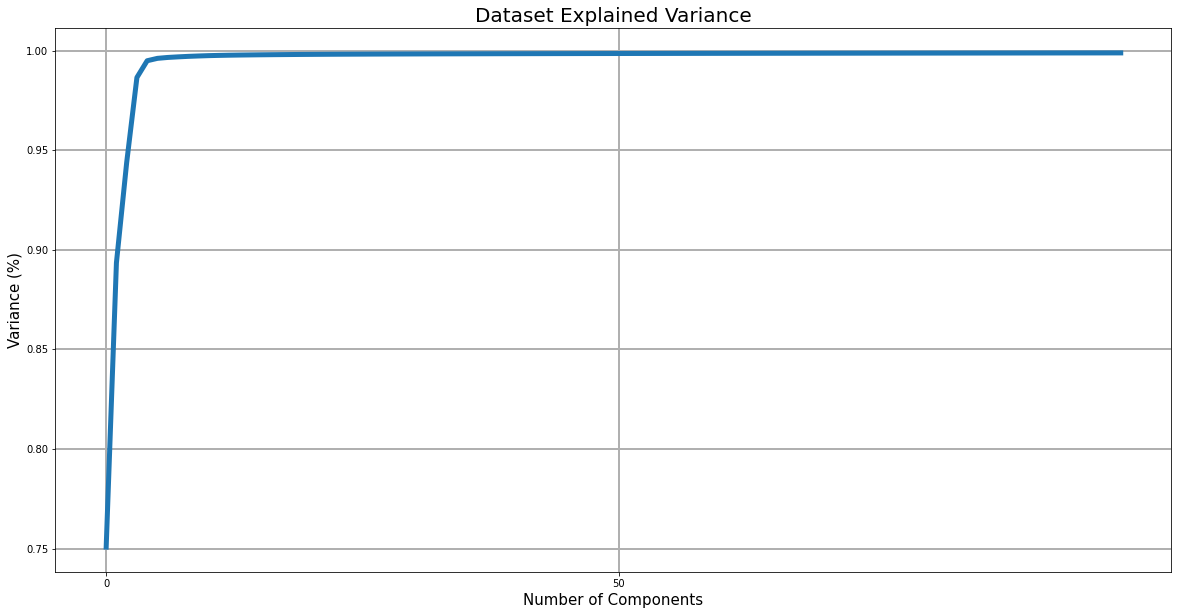

In [38]:
from sklearn.decomposition import PCA

#Fitting the PCA algorithm with our Data
pca = PCA().fit(word_vectors.vectors)

plt.figure()
plt.figure(figsize=(20,10))

plt.plot(np.cumsum(pca.explained_variance_ratio_)[:100],linewidth=5)
plt.xlabel('Number of Components', fontsize=15)
plt.ylabel('Variance (%)', fontsize=15) #for each component
plt.title('Dataset Explained Variance', fontsize=20)
plt.grid(linestyle='-', linewidth=2)
plt.xticks(np.arange(0, 100, 50))
plt.show()

In [13]:
components = 2

In [14]:
pca = PCA(n_components = components)
pca.fit(word_vectors.vectors)
X_features = pca.transform(word_vectors.vectors)

In [20]:
print('Variance in PCA tranformed dataset:', pca.explained_variance_ratio_.sum())

Variance in PCA tranformed dataset: 0.8934479


In [22]:
print('Shape of PCA tranformed dataset:', X_features.shape)

Shape of PCA tranformed dataset: (3261, 2)


In [23]:
from sklearn.metrics import silhouette_score,davies_bouldin_score

In [24]:
def SSE_clusters(data, max_k):
    iters = range(2, max_k+1, 2)
    
    sse = []
    for k in iters:
        sse.append(KMeans(n_clusters=k, random_state=42).fit(data).inertia_)
        print('Fit {} clusters'.format(k))
        
    from IPython.display import clear_output
    clear_output()
    
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')

In [25]:
def Silhouette_clusters(data, max_k):
    iters = range(2, max_k+1, 2)
    
    silhouettes = []
    for k in iters:
        clusters = []
        clusters = KMeans(n_clusters=k, random_state=42).fit_predict(data)
        silhouettes.append(silhouette_score(data,clusters))
        print('Fit {} clusters'.format(k))
        
    from IPython.display import clear_output
    clear_output()
    
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, silhouettes, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('Silhouette Score')
    ax.set_title('Silhouett by Cluster Center Plot')

In [26]:
def DBI_clusters(data, max_k):
    iters = range(2, max_k+1, 2)
    
    dbi = []
    for k in iters:
        clusters = []
        clusters = KMeans(n_clusters=k, random_state=42).fit_predict(data)
        dbi.append(davies_bouldin_score(data,clusters))
        print('Fit {} clusters'.format(k))
        
    from IPython.display import clear_output
    clear_output()
    
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, dbi, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('Davies Bouldin Index')
    ax.set_title('DBI by Cluster Center Plot')

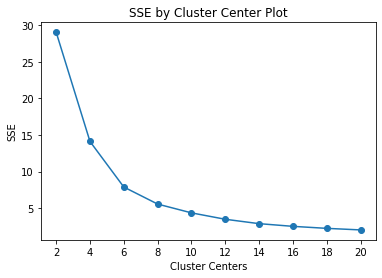

In [55]:
SSE_clusters(X_features, 20)

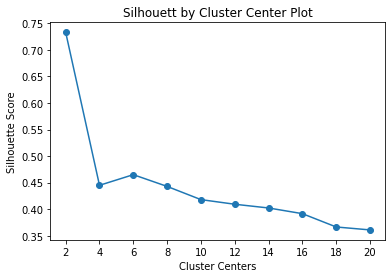

In [28]:
Silhouette_clusters(X_features, 20)

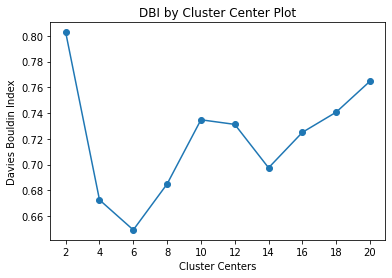

In [57]:
DBI_clusters(X_features, 20)

## K-means

In [30]:
clus_num = 5

In [31]:
model = KMeans(n_clusters=clus_num, random_state=42)
clusters = model.fit_predict(X_features)

In [60]:
from sklearn.metrics import silhouette_score,davies_bouldin_score
print('Silhouette:',silhouette_score(X_features,clusters))
print('Davies-Bouldin:',davies_bouldin_score(X_features,clusters))

Silhouette: 0.5165062
Davies-Bouldin: 0.6539657492009154


In [33]:
%matplotlib inline

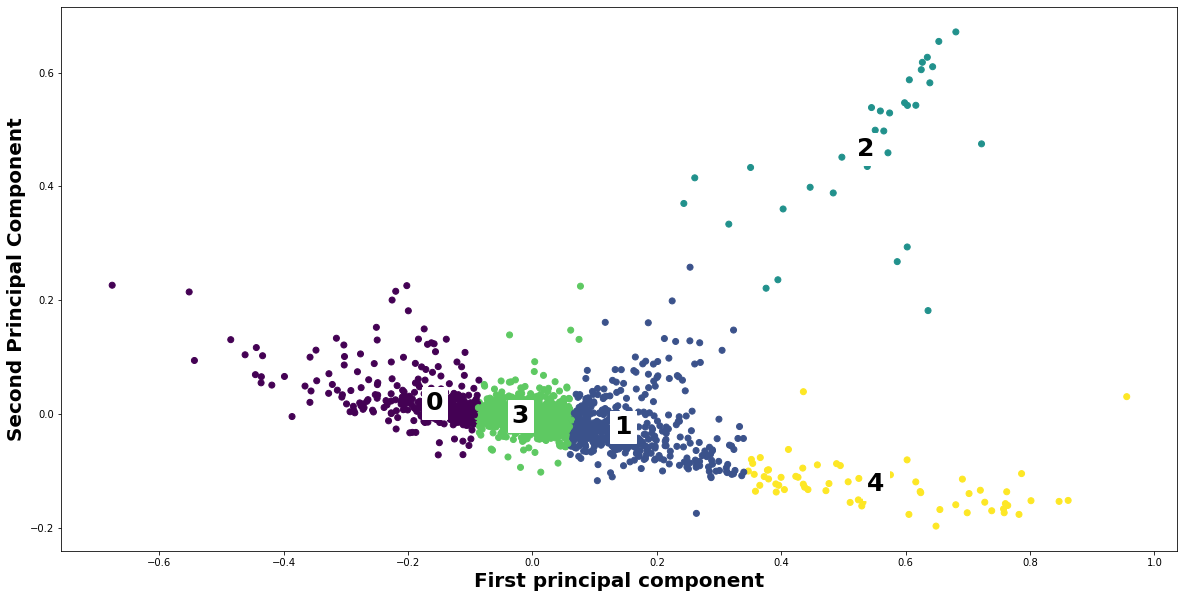

In [34]:
plt.figure(figsize=(20,10))
plt.scatter(X_features[:,0],X_features[:,1], c=clusters, cmap='viridis')
plt.xlabel('First principal component',fontsize=20,weight='bold')
plt.ylabel('Second Principal Component',fontsize=20, weight='bold')

customPalette = ['#630C3A', '#39C8C6', '#D3500C', '#FFB139']

for i in range(clus_num):
    plt.annotate(str(i),(model.cluster_centers_[i][0],model.cluster_centers_[i][1]),
                 horizontalalignment='center',
                 verticalalignment='center',
                 size=25, weight='bold',
                 color='black',backgroundcolor='white') 